# Biometric Systems - Laboratory 2

In [32]:
# Libraries Import
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure, filters
from scipy.stats import entropy
from PIL import Image

sns.set_palette("viridis")

# List of image files
image_files = ['TestImages/bird.gif', 'TestImages/camera.gif', 'TestImages/lena.gif', 
               'TestImages/squares.gif', 'TestImages/peppers_gray.tif', 
               'TestImages/101_1.tif', 'TestImages/101_2.tif', 'TestImages/101_3.tif']

# Function to load images
def load_images(file_list):
    """Load a list of images from file paths."""
    images = []
    for file in file_list:
        if file.endswith('.gif'):
            try:
                img = Image.open(file).convert('L')  # Convert to grayscale
                images.append(np.array(img))
            except Exception as e:
                print(f"Failed to load image: {file}. Error: {e}")
        else:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
            else:
                print(f"Failed to load image: {file}")
    return images

loaded_images = load_images(image_files)

# Path to the main folder for fingerprint images
fingerprints_folder = "./FingerprintImages/"

# Collect all image paths
fingerprint_files = []
for subfolder in os.listdir(fingerprints_folder):
    subfolder_path = os.path.join(fingerprints_folder, subfolder)
    if os.path.isdir(subfolder_path):  # Ensure it's a subfolder
        for file_name in os.listdir(subfolder_path):
            if file_name.endswith('.bmp'):  # Check for BMP images
                fingerprint_files.append(os.path.join(subfolder_path, file_name))

In [36]:
# Helper functions
def compute_entropy(image):
    """Compute the entropy of an image."""
    histogram, _ = np.histogram(image, bins=256, range=(0, 255), density=True)
    return entropy(histogram)

def plot_images(images, titles, cmap='gray'):
    """Plot a set of images with titles and their histograms below."""
    n = len(images)
    fig, axes = plt.subplots(2, n, figsize=(15, 10))
    for i in range(n):
        # Plot image
        axes[0, i].imshow(images[i], cmap=cmap)
        axes[0, i].set_title(titles[i])
        axes[0, i].axis('off')
        
        # Plot histogram
        sns.histplot(images[i].ravel(), bins=256, kde=False, ax=axes[1, i], color='blue')
        axes[1, i].set_title(f"Histogram of {titles[i]}")
        axes[1, i].set_xlim(0, 255)
    plt.tight_layout()
    plt.show()

## Intensity Transformations
### `contrast_stretching` Function
This function applies contrast stretching to an input grayscale image.

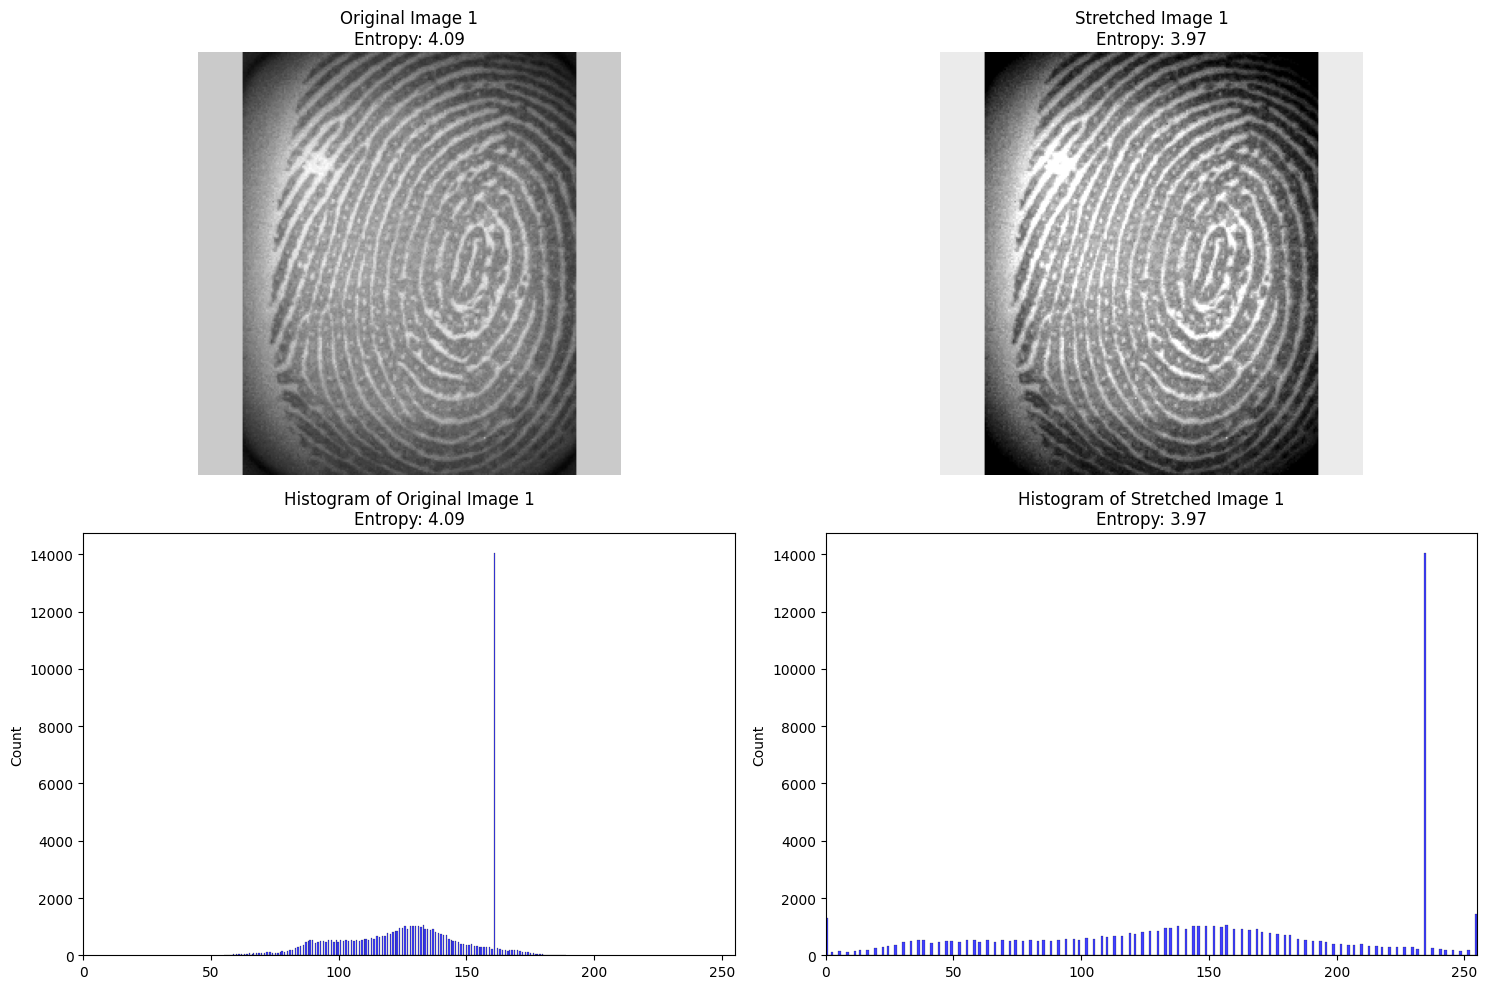

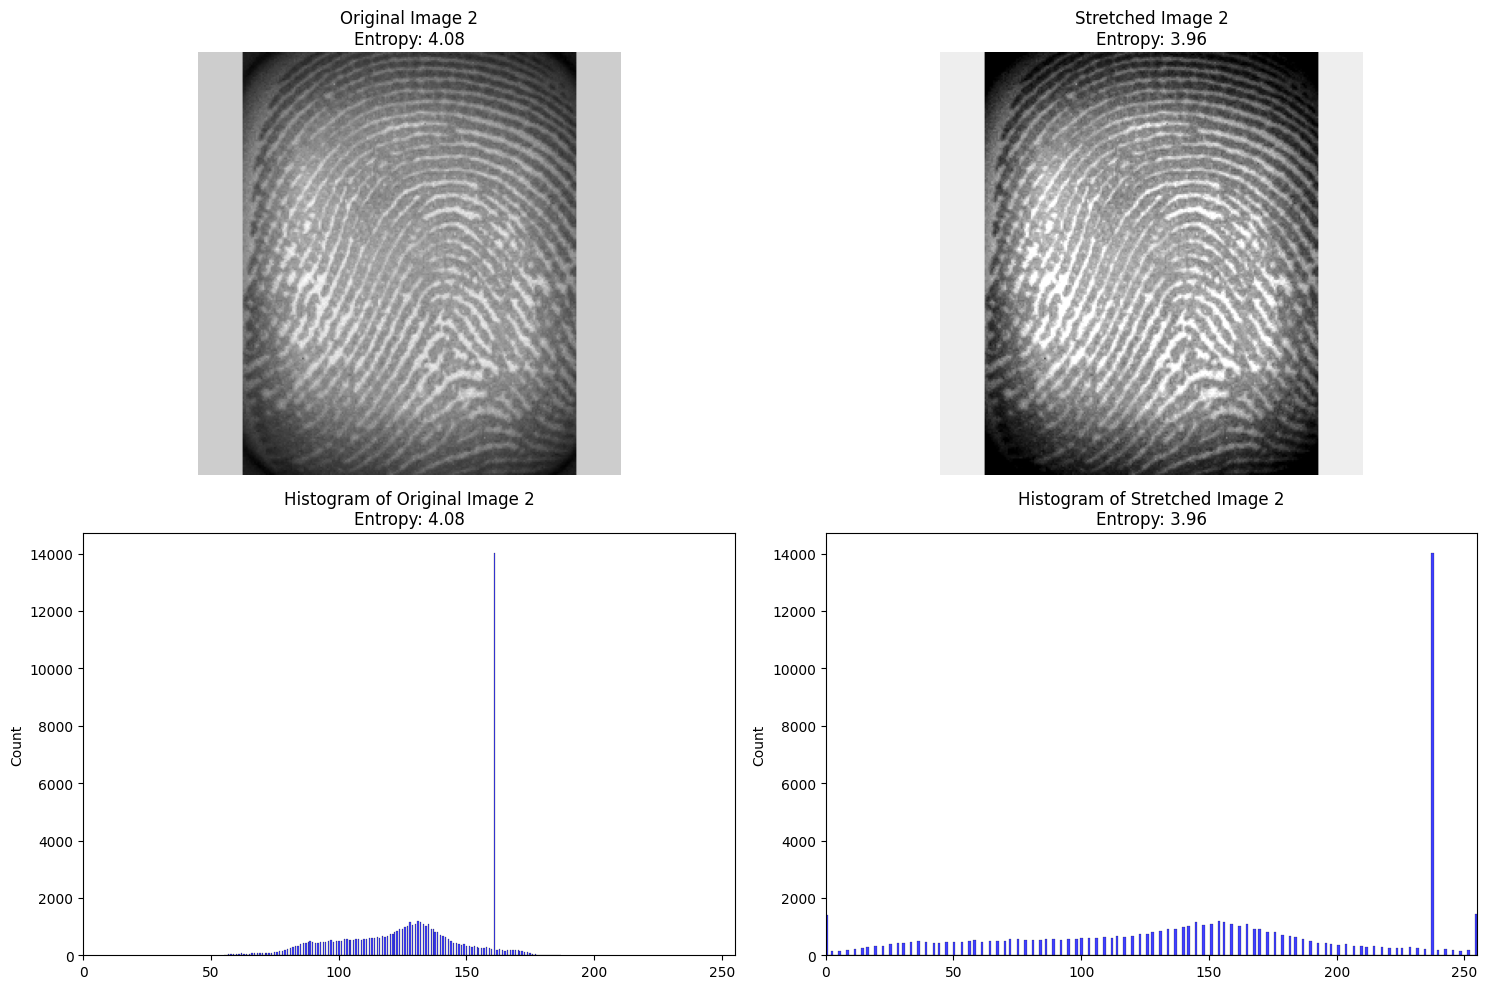

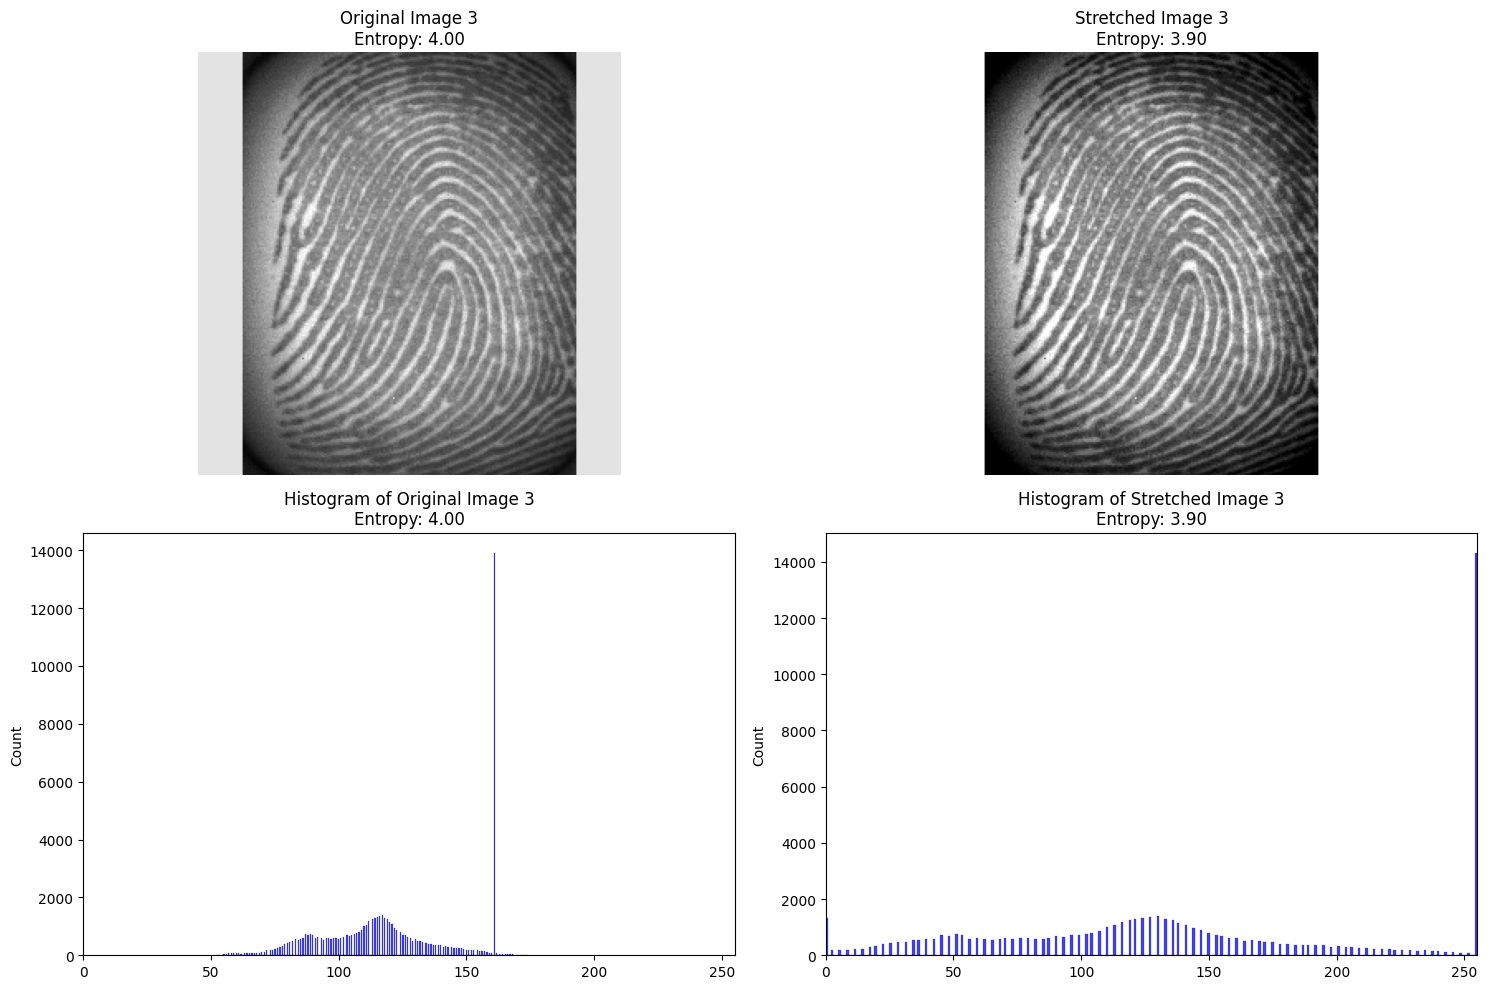

In [50]:
def contrast_stretching(image):
    """Apply contrast stretching to an image."""
    p2, p98 = np.percentile(image, (2, 98))
    stretched = exposure.rescale_intensity(image, in_range=(p2, p98))
    return stretched

image_paths = [fingerprint_files[0], fingerprint_files[3], fingerprint_files[9]]  # Use 3 fingerprint images
original_images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in image_paths]
stretched_images = [contrast_stretching(img) for img in original_images]

# Compute metrics
original_entropies = [compute_entropy(img) for img in original_images]
stretched_entropies = [compute_entropy(img) for img in stretched_images]

# Plot original and contrast-stretched images
for i, (orig, stretched) in enumerate(zip(original_images, stretched_images)):
    plot_images([orig, stretched], 
                [f"Original Image {i+1}\nEntropy: {original_entropies[i]:.2f}", 
                 f"Stretched Image {i+1}\nEntropy: {stretched_entropies[i]:.2f}"])


#### Comment
The original fingerprint images have a concentrated intensity range, with most pixel values clustered around a specific intensity. This is evident from the sharp peaks in their histograms. Entropy values for the original images are slightly higher, indicating more variability or randomness in pixel intensity.

Contrast stretching redistributes pixel values to span the full intensity range (0–255), improving the visibility of fingerprint ridges and valleys. The histograms of stretched images are more evenly distributed, reflecting the broader range of pixel intensities achieved through contrast stretching. Entropy values for the stretched images are slightly reduced compared to the originals, likely due to the redistribution reducing minor variations in pixel intensities.

The stretched images exhibit improved contrast, making the fingerprint patterns more distinct and visually clear. This enhances the usability of the images for further processing, such as feature extraction.

### Histogram Equalization and Specification

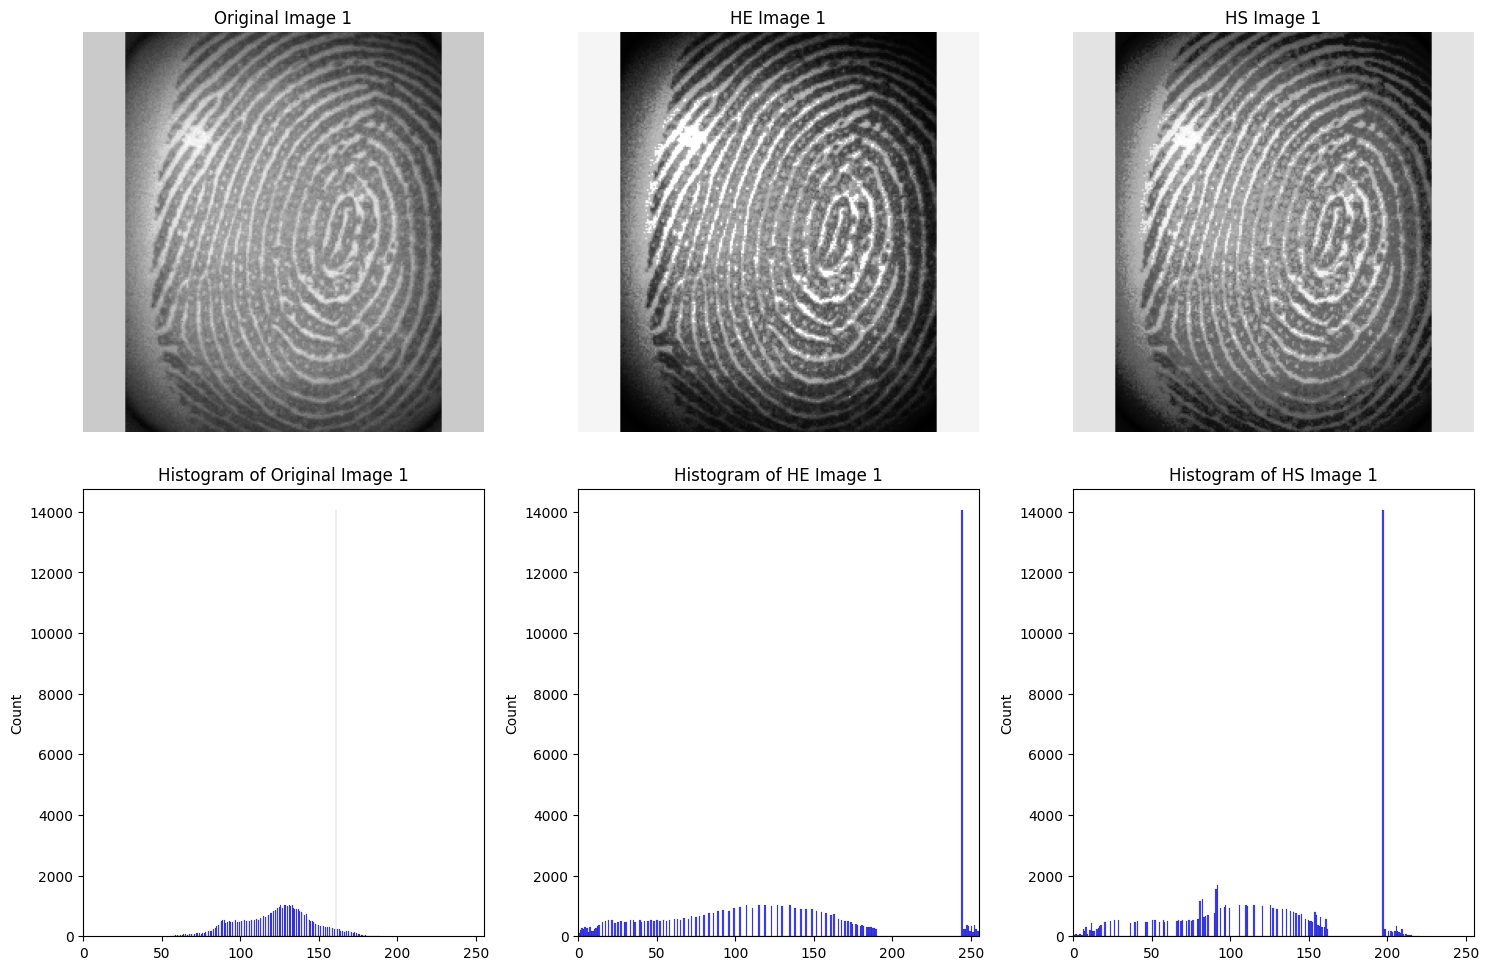

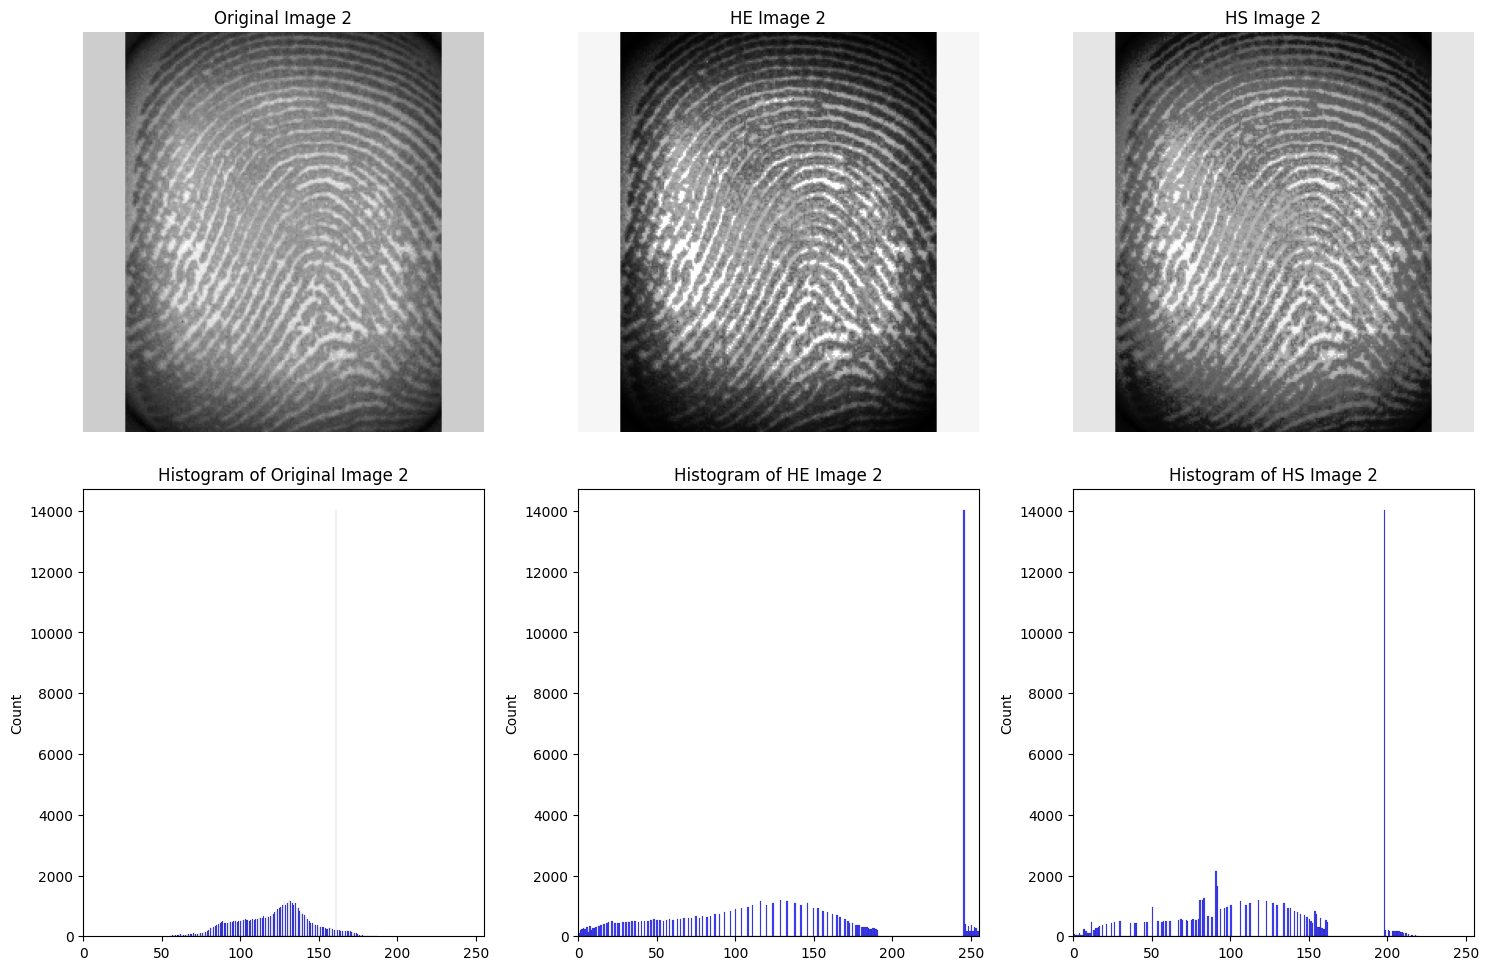

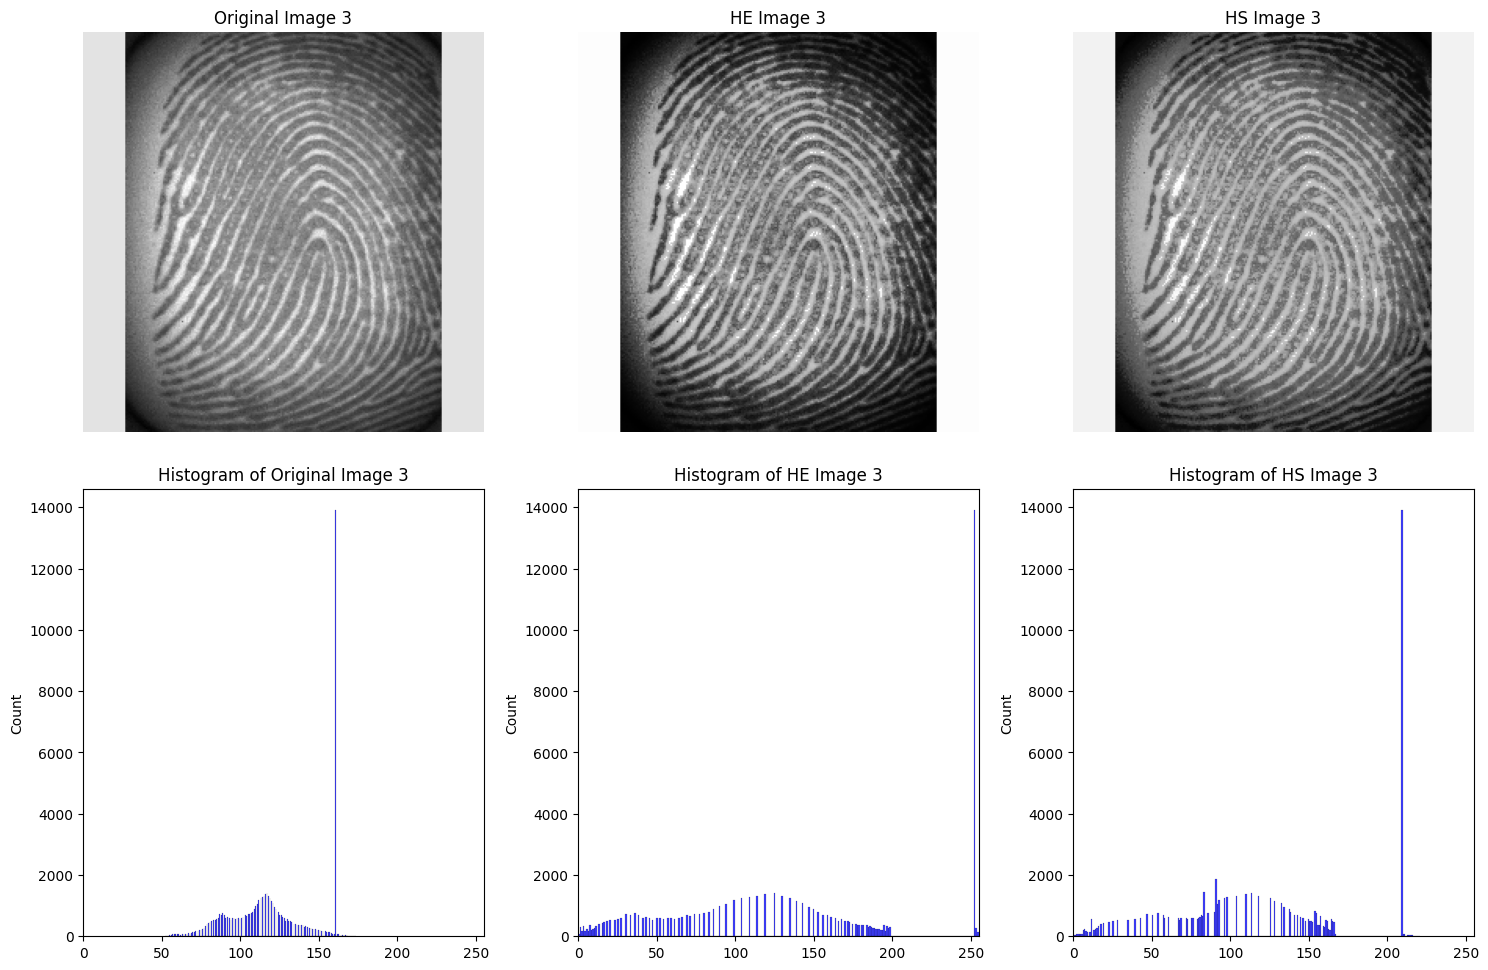

In [51]:
he_images = [cv2.equalizeHist(img) for img in original_images]
reference_image = loaded_images[4]  # Squares image for histogram specification

hs_images = []
for img in original_images:
    matched = exposure.match_histograms(img, reference_image)
    hs_images.append(matched)

# Plot HE and HS results
for i, (orig, he, hs) in enumerate(zip(original_images, he_images, hs_images)):
    plot_images([orig, he, hs], 
                [f"Original Image {i+1}", f"HE Image {i+1}", f"HS Image {i+1}"])

#### Comment
The results, using squares.gif as the reference image, highlight distinct differences between the original images, Histogram Equalization (HE), and Histogram Specification (HS). The original fingerprint images have poor contrast, with pixel intensities clustered in a narrow range, as shown by their histograms. This limits the visibility of ridges and valleys.

With HE, the intensity values are redistributed uniformly across the entire range, significantly enhancing contrast. This makes the fingerprint patterns much clearer, but the enhancement is aggressive, sometimes resulting in over-brightened regions. The histograms of the HE images demonstrate a uniform spread of intensities.

In contrast, HS matches the intensity distribution to the reference image (squares.gif), providing a subtler, more structured enhancement. The fingerprint details are improved, but with smoother transitions and fewer artifacts compared to HE. The histograms of the HS images closely resemble the intensity profile of the reference image.

Overall, HE is ideal for applications requiring aggressive contrast enhancement, while HS offers a controlled and reference-aligned improvement, preserving the structured appearance of the fingerprints.

## Spatial Filtering
### Sharpening Fingerprint Images
This cell applies a sharpening filter to highlight ridges in fingerprint images.

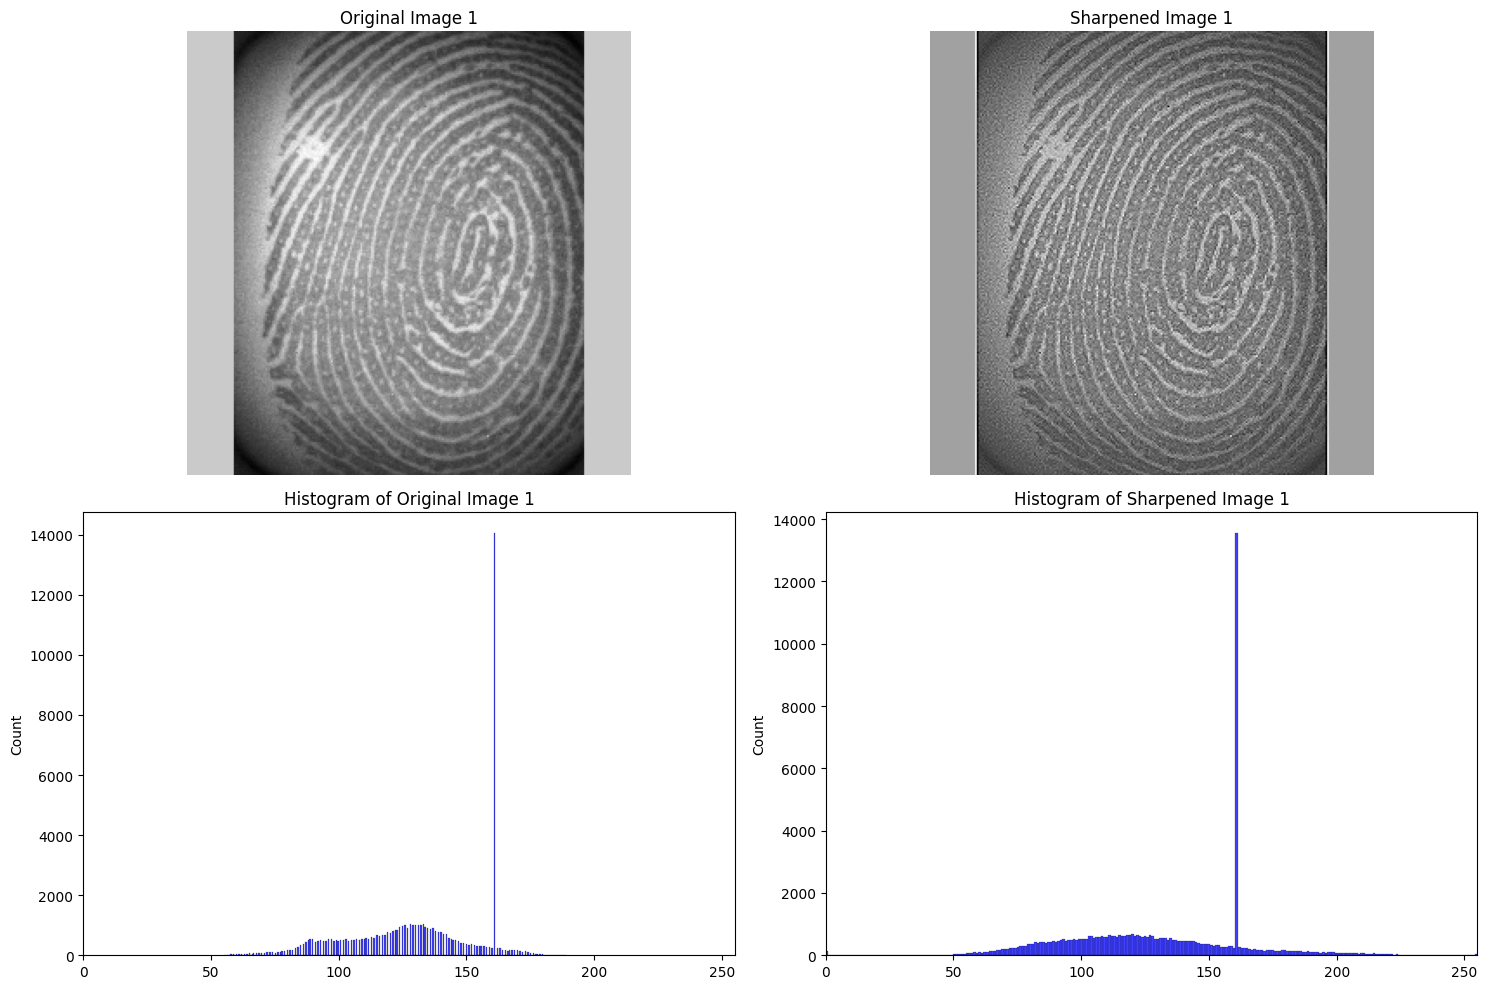

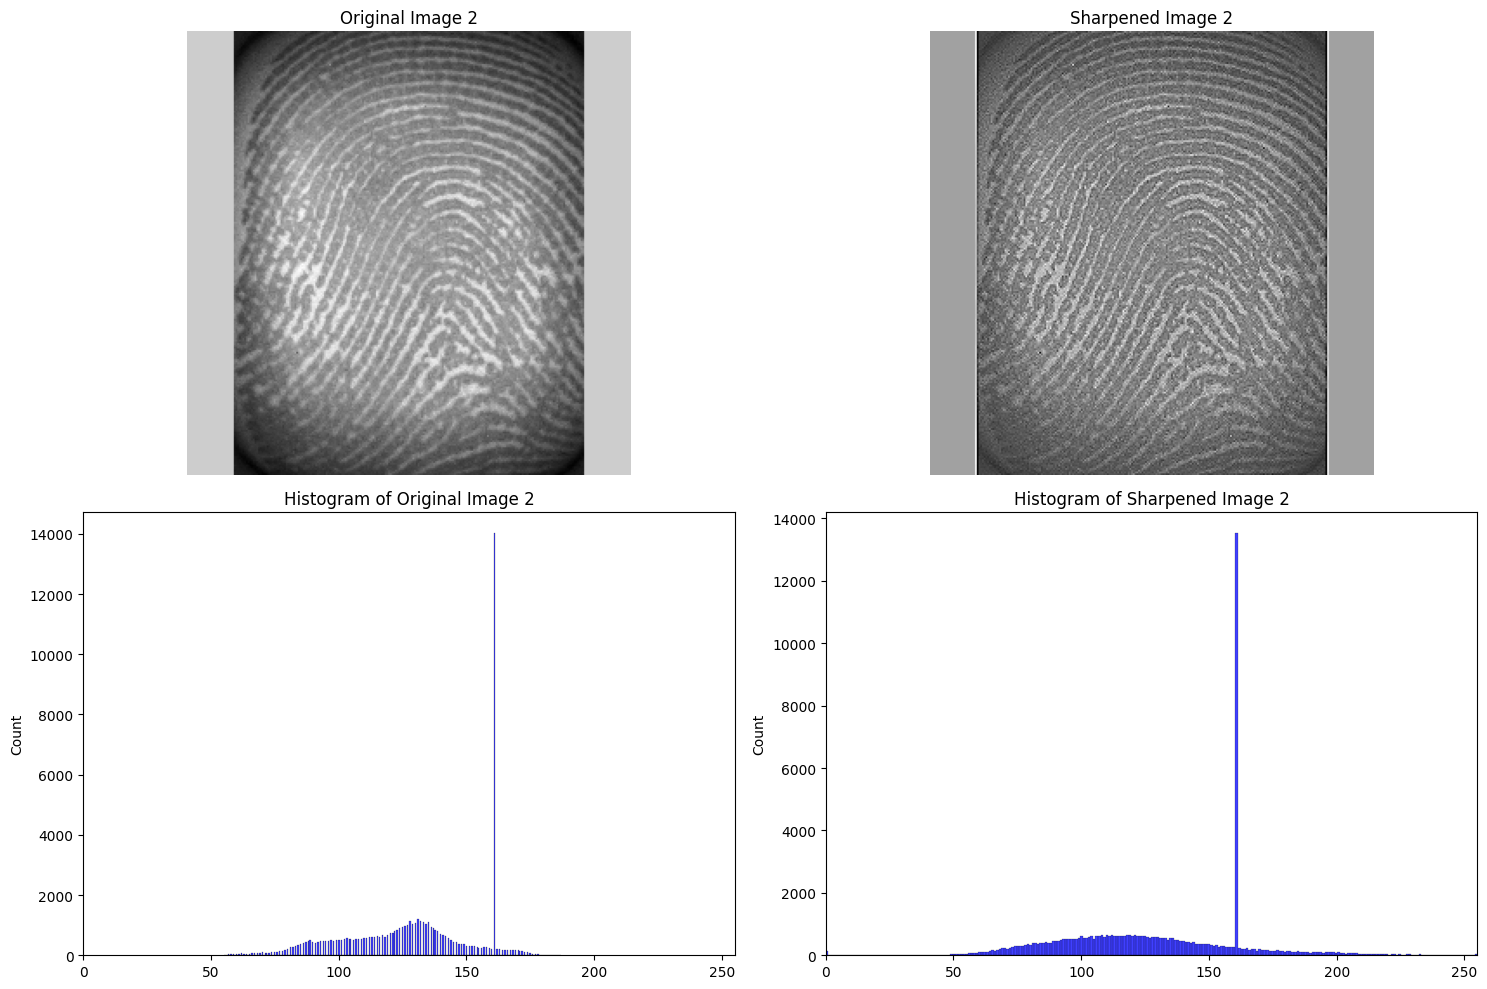

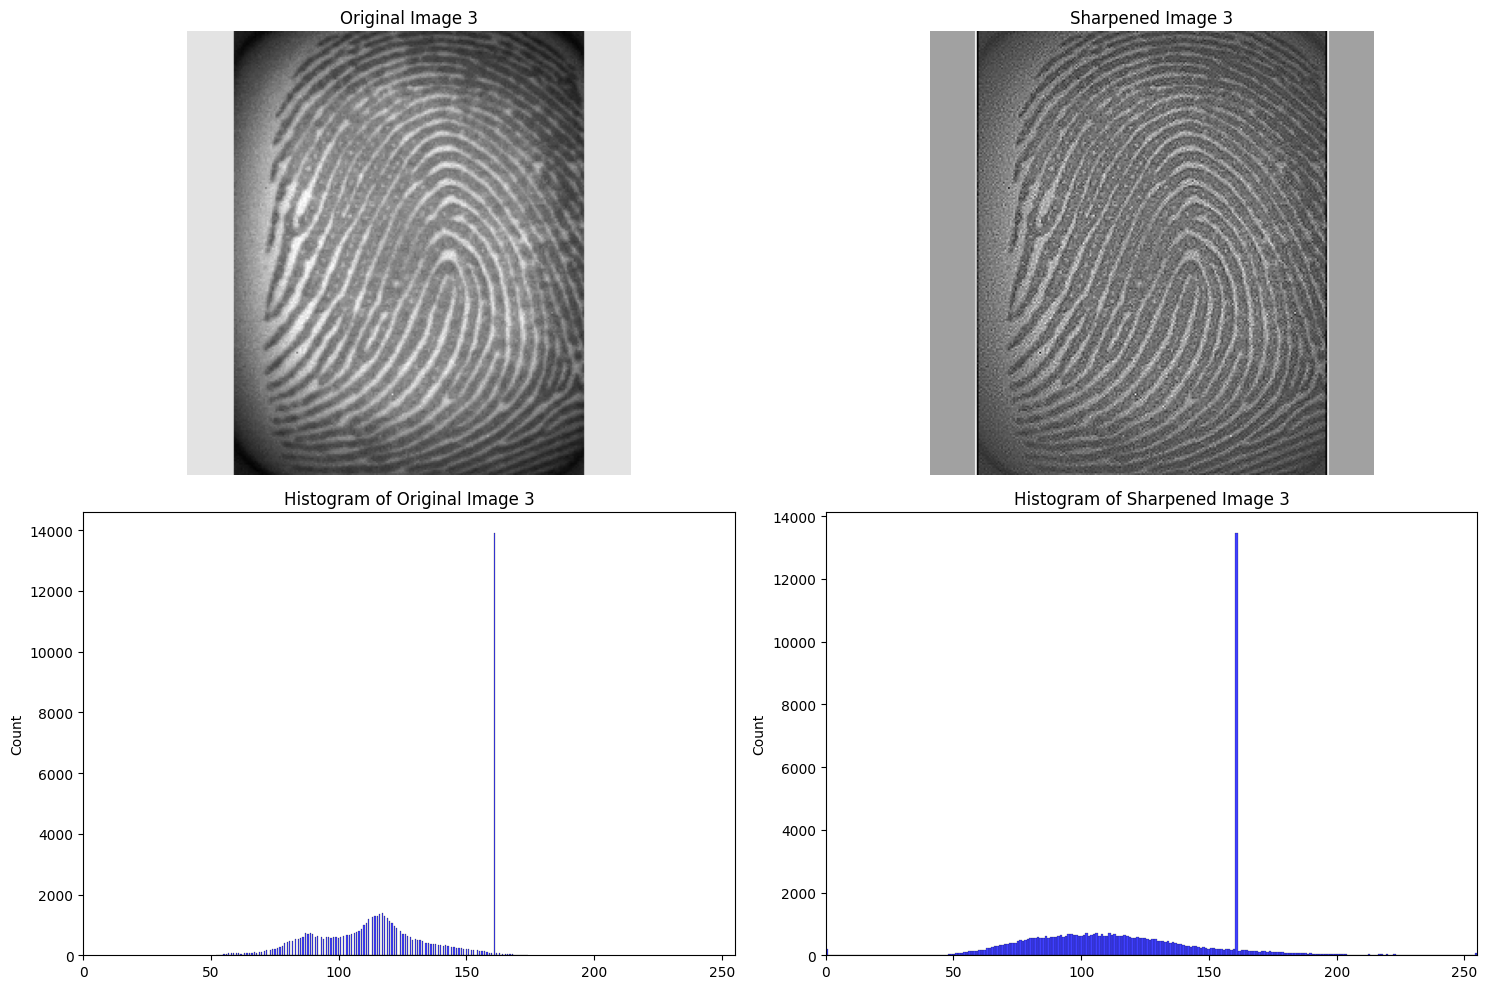

In [52]:
sharpened_images = []
for img in original_images:
    kernel = np.array([[0, -1, 0], 
                       [-1, 5, -1], 
                       [0, -1, 0]])  # Sharpening kernel
    sharpened = cv2.filter2D(img, -1, kernel)
    sharpened_images.append(sharpened)

# Plot sharpened images
for i, (orig, sharp) in enumerate(zip(original_images, sharpened_images)):
    plot_images([orig, sharp], 
                [f"Original Image {i+1}", f"Sharpened Image {i+1}"])

#### Comment
The sharpening results for the fingerprint images demonstrate significant improvements in edge clarity and contrast. The original images show visible fingerprint patterns, but the ridges and valleys lack sharpness, making them less distinct. The histograms of the original images are concentrated in a narrow intensity range, reflecting limited contrast and edge definition.

In the sharpened images, the fingerprint ridges and valleys become more pronounced and easier to distinguish, with enhanced edge details. This improvement is clearly visible, particularly in the contrast between the ridges and valleys. The histograms of the sharpened images show slightly broader distributions, indicating increased intensity variation caused by the edge enhancement process.

### Binary Conversion
This cell computes the binary version of a sharpened image using binary thresholding.

In [54]:
def plot_images(images, titles, cmap='gray'):
    """Plot a set of images with titles."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=cmap)
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

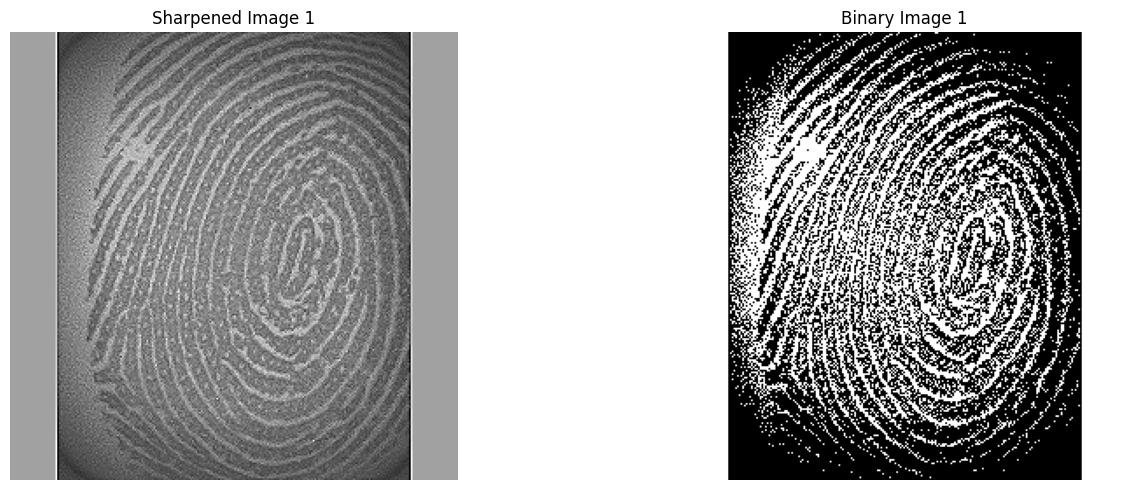

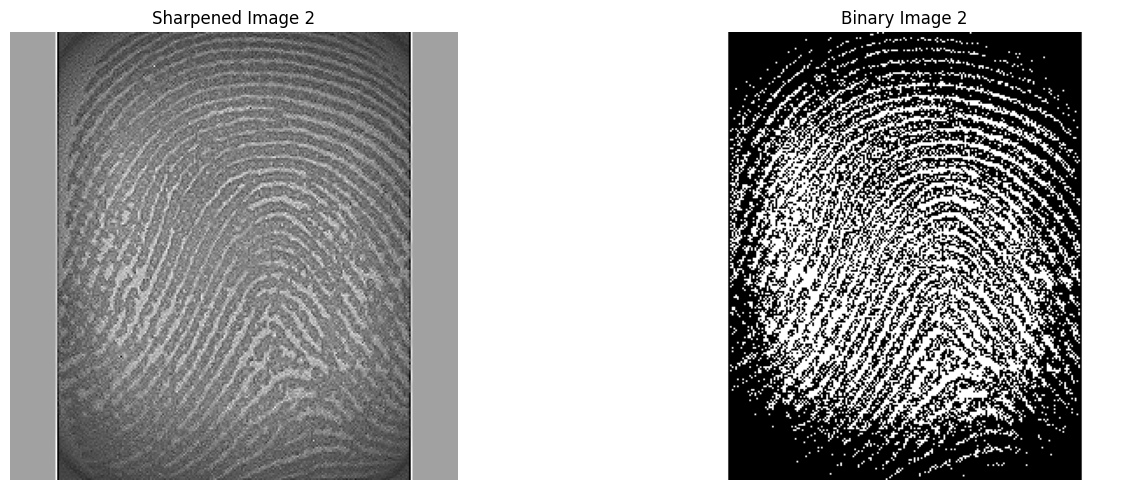

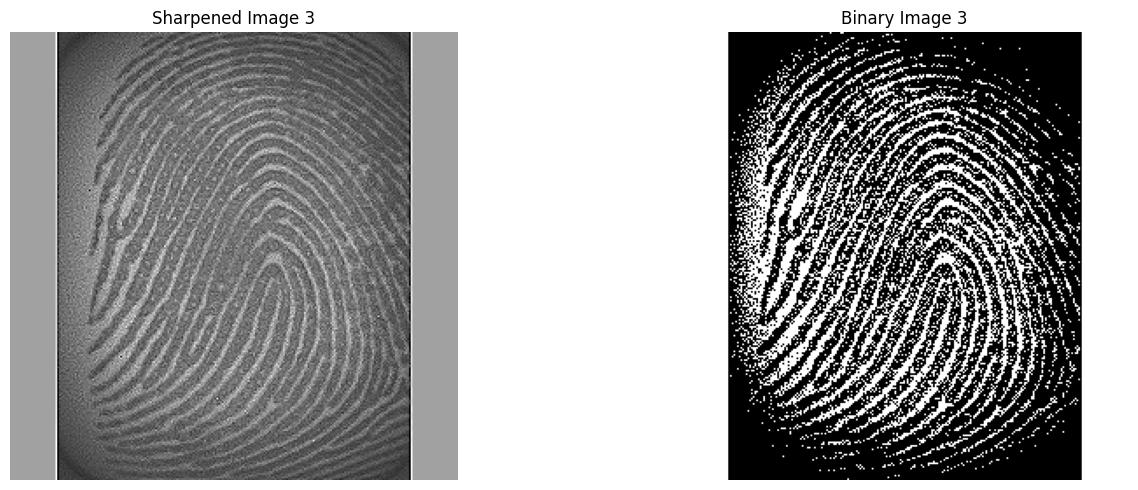

In [55]:
binary_images = [(sharp > filters.threshold_otsu(sharp)).astype(np.uint8) * 255 for sharp in sharpened_images]

# Plot binary images
for i, binary in enumerate(binary_images):
    plot_images([sharpened_images[i], binary], 
                [f"Sharpened Image {i+1}", f"Binary Image {i+1}"])

#### Comment
The binary conversion of sharpened fingerprint images highlights the ridges and valleys of the patterns effectively. The sharpened images enhance the fingerprint details, making the ridges and valleys more distinct, which is essential for accurate binary conversion.

In the binary images, the fingerprint patterns are clearly visible, with ridges appearing as white regions and valleys as black regions. This high-contrast representation is well-suited for tasks such as feature extraction and biometric matching. However, some background noise is present, and minor discontinuities are observed in certain ridge lines, which might require additional preprocessing to improve the overall quality.

Overall, the binary conversion isolates the fingerprint patterns effectively, but further refinement could enhance the quality of the binary images, making them even more suitable for downstream biometric analysis.